In [1]:
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import make_scorer, mean_absolute_error, roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_union
from sklearn.preprocessing import FunctionTransformer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate

from category_encoders import OrdinalEncoder, OneHotEncoder, CountEncoder

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from pathlib import Path
import config

sys.path.append('./starspace36_mono_model')
# import starspace_resources as sw_resources

pd.set_option('display.max_rows', 120)
plt.style.use("dark_background")
plt.rcParams['figure.figsize'] = (20, 15)

print(Path.cwd())

/home/sergey/mnt/st1500/Usr/Sergey/TheJob/Otus/ML_advanced2020/home_works/1. Auto_ML/drivendata_flu_shot


In [2]:
X = pd.read_csv("./input/training_set_features.csv", index_col='respondent_id')
y = pd.read_csv("./input/training_set_labels.csv", index_col='respondent_id')
submission_format = pd.read_csv("./input/submission_format.csv", index_col='respondent_id')
test_set = pd.read_csv("./input/test_set_features.csv", index_col='respondent_id')

In [3]:
print('y.head()')
y.head()


y.head()


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [4]:
#  Encoders

ordinal_label_encoder_pipe = Pipeline([

    ('label-encoder', OrdinalEncoder(cols=config.categorical)),
    # ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('scaler', StandardScaler()),
    # ('regressor', BayesianRidge())
])

In [5]:
print("test_set")
test_set.head()


test_set


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [6]:
# split for starspace and catboost datasets
X.replace(to_replace=config.ordinal_to_replace, inplace=True)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3)

In [7]:
X_hyper_encoder = ordinal_label_encoder_pipe.fit(X=X)
X_hyper = X_hyper_encoder.transform(X).astype(dtype=str)

/home/sergey/anaconda3/envs/ML_advanced2020.python3.6/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [8]:
# ordinal_encoder = ordinal_label_encoder_pipe.fit(X=X_train)
# X_train = pd.DataFrame(data=ordinal_encoder.transform(X_train),
#                  index=X_train.index,
#                  columns=X_train.columns).astype(int, errors='ignore')
#
# X_train
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_train.dtypes != int))

In [9]:
# X_test = pd.DataFrame(data=ordinal_encoder.transform(X_test),
#                  index=X_test.index,
#                  columns=X_test.columns).astype(int, errors='ignore')
#
# print('X_test')
# print('есть ли после трансформации OrdinalEncoder значения не int', any(X_test.dtypes != int))

In [10]:
test_set.replace(to_replace=config.ordinal_to_replace, inplace=True)
test_set = pd.DataFrame(data=X_hyper_encoder.transform(test_set),
                 index=test_set.index,
                 columns=test_set.columns).astype(int, errors='ignore')

test_set = test_set.astype(str)


In [11]:
h1n1_train_counts = y.h1n1_vaccine.value_counts()
# h1n1_test_counts = y.h1n1_vaccine.value_counts()

print("соотношения классов")
print(f"h1n1_train_counts train \n {h1n1_train_counts.values} {h1n1_train_counts[1] / h1n1_train_counts[0]}")
# print("h1n1_test_counts test \n", h1n1_test_counts.values, h1n1_test_counts[1] / h1n1_test_counts[0])

соотношения классов
h1n1_train_counts train 
 [21033  5674] 0.26976655731469595


In [12]:
# X_train = X_train.astype(dtype=str)
# X_test = X_test.astype(dtype=str)


In [13]:

def hyperopt_ctb_score(params):

    clf = CatBoostClassifier(**params)
    current_validation = cross_validate(
        estimator=clf,
        X=X_hyper,
        y=y_hyper,
        cv=3,
    )

    current_score = current_validation['test_score'].mean()
    result = {
        'loss': -current_score,
        'status': STATUS_OK,

        # -- store other results like this
        'eval_time': time.time(),
        'other_stuff': {'type': None, 'value': [0, 1, 2]},
        # -- attachments are handled differently
        'attachments':
            {'model': 'model'}
    }
    return result

catboost_space = {
            # 'iterations': hp.choice('iterations', range(100, 1000)),
            'learning_rate': hp.quniform('learning_rate', 4e-3, 3e-2, 1e-3),
            'depth':  hp.choice('depth', np.arange(1, 14, dtype=int)),
}

In [14]:
hyper_best_params = {}
for col in y.columns:
    y_hyper = y[col]

    hyperopt_local_params = config.params.copy()
    hyperopt_local_params.update(catboost_space)

    trials = Trials()
    best = fmin(fn=hyperopt_ctb_score, space=hyperopt_local_params, algo=tpe.suggest, max_evals=2, trials=trials)
    print('best:', col)
    print(best)
    hyperopt_local_params.update(best)
    hyper_best_params[col] = hyperopt_local_params

0:	total: 68.5ms	remaining: 17.1s                    

100:	total: 1.5s	remaining: 2.21s                    

200:	total: 3.24s	remaining: 790ms                   

249:	total: 4.03s	remaining: 0us                     

0:	total: 16.9ms	remaining: 4.21s                    

100:	total: 1.56s	remaining: 2.3s                    

200:	total: 3.44s	remaining: 838ms                   

249:	total: 4.26s	remaining: 0us                     

0:	total: 26.6ms	remaining: 6.63s                    

100:	total: 2s	remaining: 2.95s                      

200:	total: 3.85s	remaining: 940ms                   

249:	total: 4.88s	remaining: 0us                     

0:	total: 33.3ms	remaining: 8.29s                                               

100:	total: 2.2s	remaining: 3.24s                                               

200:	total: 3.69s	remaining: 901ms                                              

249:	total: 4.43s	remaining: 0us                                                

0:	total: 16

In [15]:
# model training
models = {}
for col in y.columns:
    train_set = Pool(data=X_hyper, label=y[col], cat_features=X_hyper.columns)
    params = hyper_best_params[col]

    model = CatBoostClassifier(**params)
    model.fit(train_set)

    models[col] = model
print('model training ok')

0:	total: 68.1ms	remaining: 17s
100:	total: 5.35s	remaining: 7.89s
200:	total: 11.2s	remaining: 2.73s
249:	total: 14.2s	remaining: 0us
0:	total: 78ms	remaining: 19.4s
100:	total: 6.07s	remaining: 8.96s
200:	total: 11.9s	remaining: 2.9s
249:	total: 16.5s	remaining: 0us
model training ok


h1n1_vaccine
seasonal_vaccine


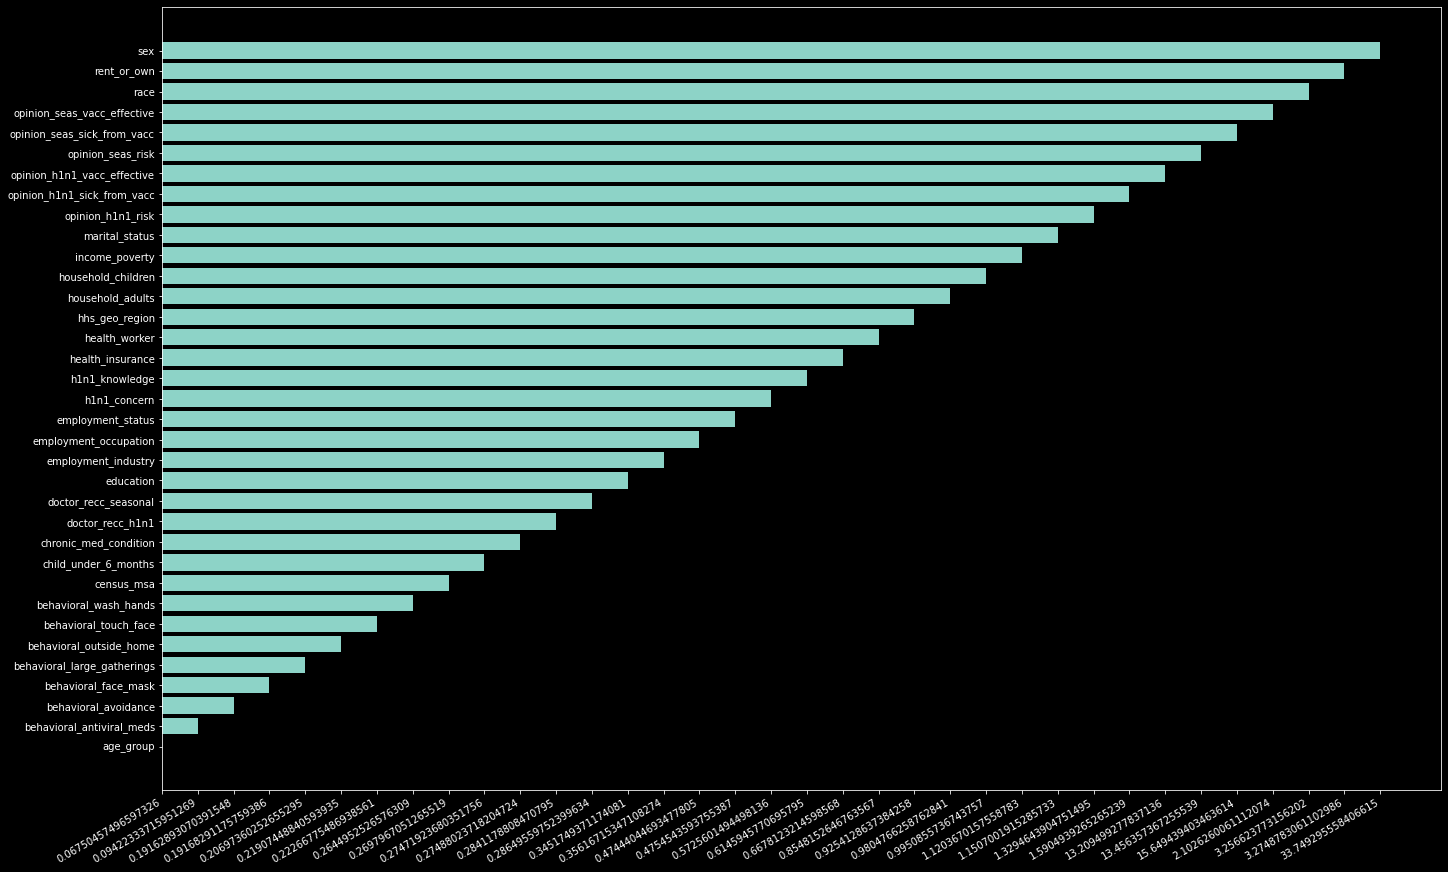

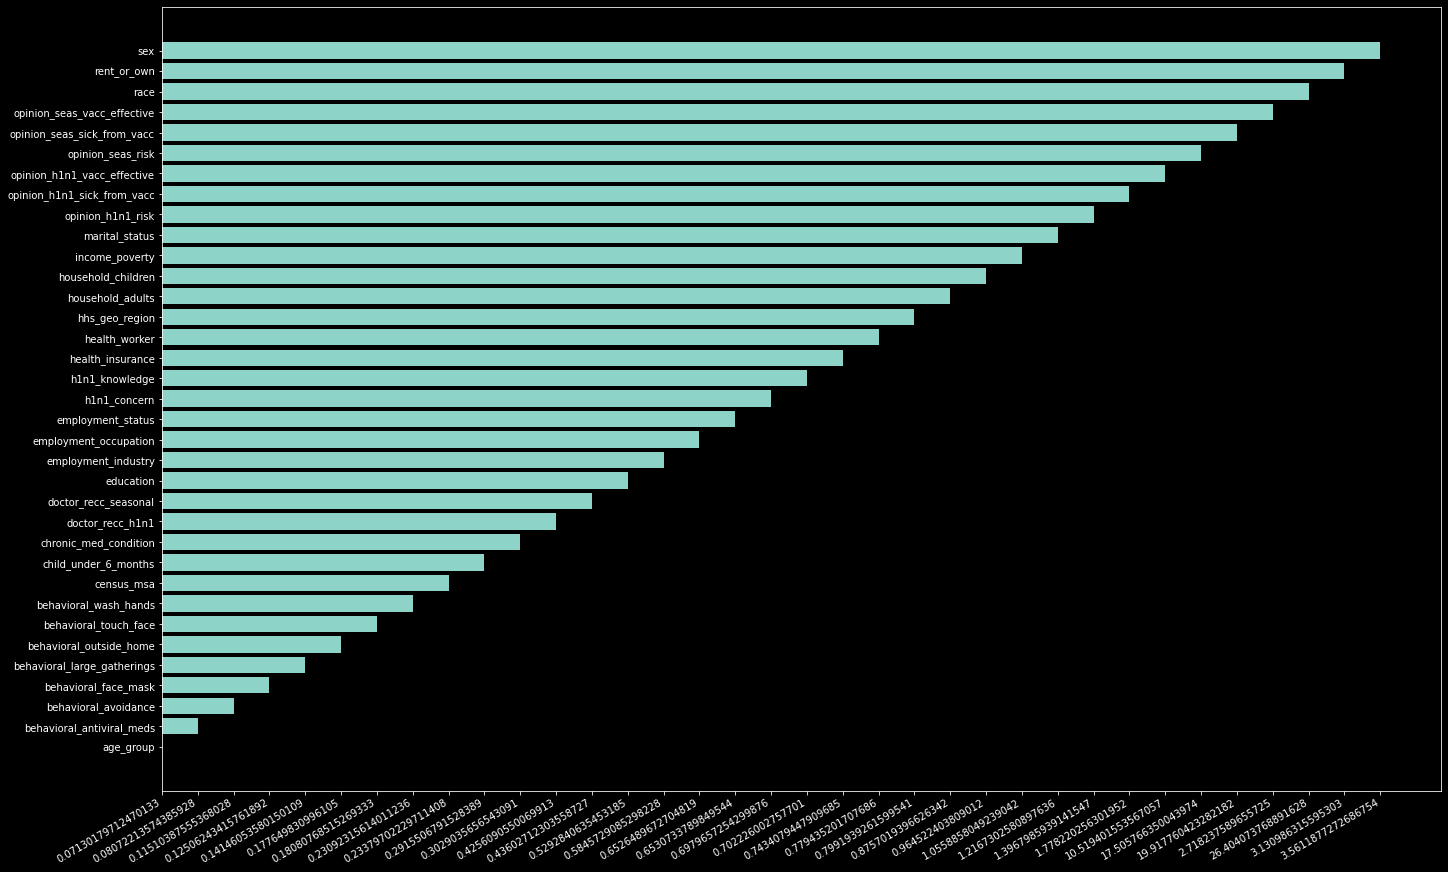

In [16]:
for model_name, model in models.items():
    print(model_name)
    for feature_name, feature_importance in zip(model.feature_names_, model.feature_importances_):
        if feature_importance < 0.01:
            print( feature_name, feature_importance)

    importances_np = np.sort(np.array([model.feature_importances_, model.feature_names_]), axis=1)

    fig, ax = plt.subplots(figsize=(20, 12), constrained_layout=True)
    ax.barh(importances_np[1], importances_np[0], align='center');
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")


In [17]:
print("submission")

submission_df = pd.DataFrame(index=test_set.index)

for col, model in models.items():
    test_pool = Pool(test_set, cat_features=test_set.columns)
    submission_df[col] = model.predict_proba(test_pool)[:, 1]

print("submission_df.shape", submission_df.shape)
print(submission_df.head())

submission
submission_df.shape (26708, 2)
               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.222241          0.186728
26708              0.077002          0.057554
26709              0.232620          0.668558
26710              0.758784          0.885494
26711              0.446159          0.656957


In [18]:
submission_df.describe()


,h1n1_vaccine,seasonal_vaccine
count,26708.000000,26708.000000
mean,0.291967,0.479743
std,0.260234,0.308296
min,0.038344,0.030148
25%,0.093673,0.173990
50%,0.166065,0.454821
75%,0.426152,0.798438
max,0.936444,0.966904


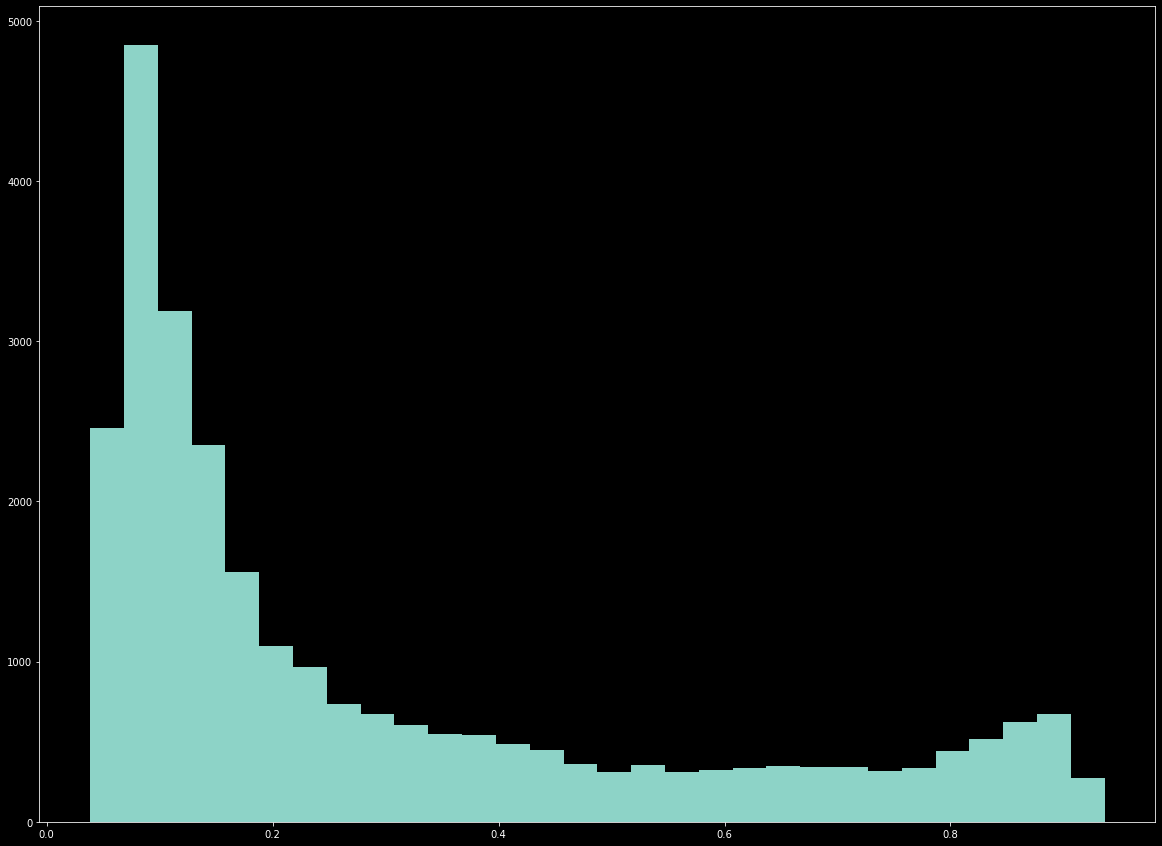

In [19]:
plt.hist(submission_df.h1n1_vaccine, bins=30);

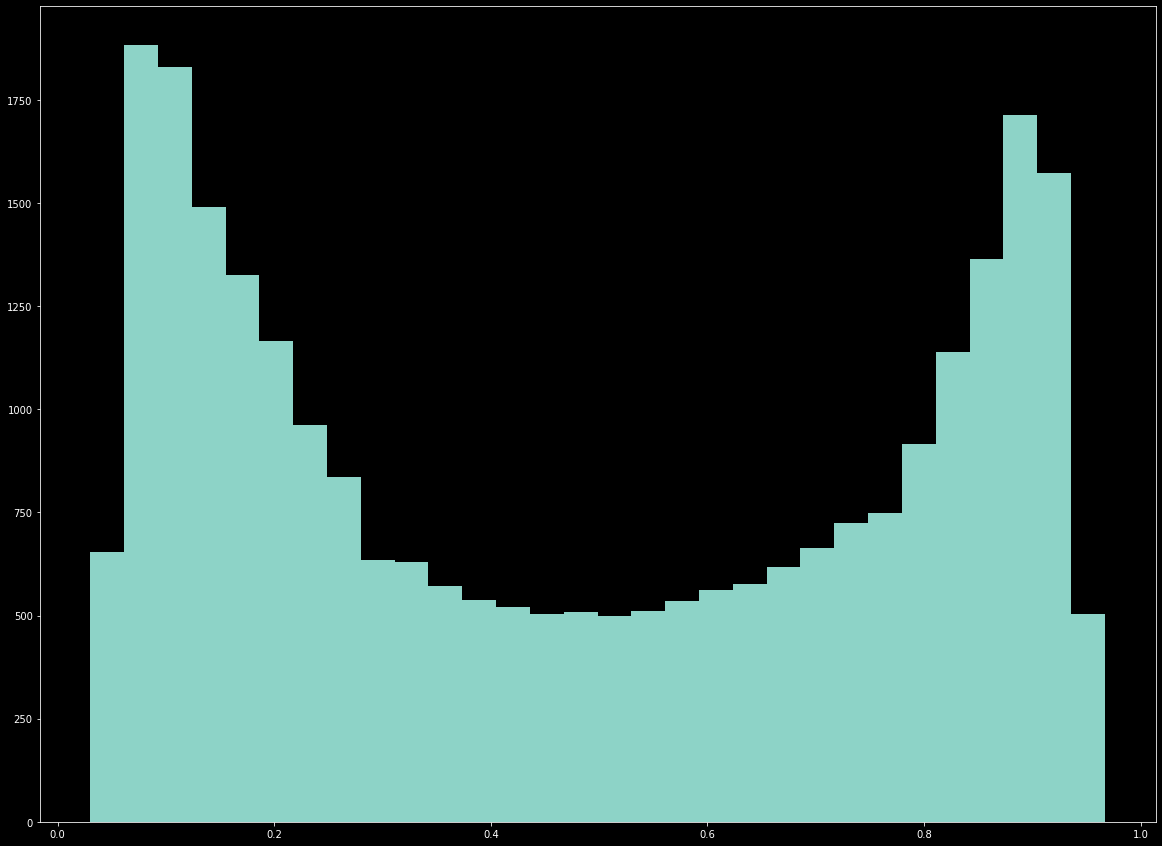

In [20]:
plt.hist(submission_df.seasonal_vaccine, bins=30);


In [21]:
submission_df.to_csv("./flu_submission1.csv")

In [22]:
print('*********   FINISH  ************')




*********   FINISH  ************
